# Importing the requiered libraries

In [45]:
import urllib, zipfile, os, shutil
import matplotlib.pyplot as plt
import numpy as np

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf
import tensorflow_addons as tfa

# Preparing the dataset

### Download the data

We first need to download the dataset, and organize it in convenient way.

In [2]:
url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip"
zip_filename = "CatsVsDogs.zip"
images_path = "PetImages"

# If zip file isn't downloaded yet => download it!
if zip_filename not in os.listdir("."):
    urllib.request.urlretrieve(url, filename = zip_filename)

# If the data inside the zip file isn't extracted yet => extract it!
if images_path not in os.listdir("."):
    with zipfile.ZipFile(zip_filename,"r") as zip_ref:
        zip_ref.extractall()

### Delete corrupted images

In [3]:
# Corrupted images are the ones that do not contain "JFIF" in their bytes representation
classes = os.listdir(images_path) # = ['Cat', 'Dog']

nb_corrupted  = 0
for c in classes:
    class_folder_path = os.path.join(images_path, c)
    image_names = os.listdir(class_folder_path)
    for image_name in image_names:
        image_path = os.path.join(class_folder_path, image_name)
        # Open the image as bytes
        try : 
            file = open(image_path, "rb")
            is_jfif = tf.compat.as_bytes('JFIF') in file.peek(10)
        finally:
            file.close()
        # If the image is corrupted then we delete it!
        if not is_jfif:
            os.remove(image_path)
            nb_corrupted+=1
            
print(f"We have deleted {nb_corrupted} corrupted images")

We have deleted 1590 corrupted images


Now, lets load the data and create our training and validation sets.

Note : Since I will be training on my CPU, instead of using the +20000 images, I will only use 3000!

* 2000 for training 
* 500 for validation
* 500 for test

In [4]:
# We will only use 3000 images
# So let's delete the remaining images
nb_images = 3000
nb_classes = len(classes)
for c in classes:
    class_folder_path = os.path.join(images_path, c)
    images = os.listdir(class_folder_path)
    if len(images) > int(nb_images / nb_classes):
        for idx in range(int(nb_images / nb_classes), len(images)):
            image_name = images[idx]
            image_path = os.path.join(class_folder_path, image_name)
            os.remove(image_path)
    print(f"We kept {len(os.listdir(class_folder_path))} images of class {c}")

We kept 1500 images of class Cat
We kept 1500 images of class Dog


In [5]:
# Lets reorganize the images based on their group (training/validation/test)
# We can implement a random procedure to pick which images to use for training, validation and test
# But since within the same group all the images are of the same class (Cats for example) then
# there is no gain in doing so !
nb_train = 2000
nb_validation = 500
nb_test = 500

# First lets create a dataset directory and its 
# sub-directories (training, validation and test)/ {Cat - Dog}
# in which we will move and organize the images
data_path = "dataset"
training_path = os.path.join(data_path, "train")
validation_path = os.path.join(data_path, "validation")
test_path = os.path.join(data_path, "test")

folder_paths = [training_path, validation_path, test_path]
for path in folder_paths:
    for c in classes:
        class_sub_directory_path = os.path.join(path, c)
        os.makedirs(class_sub_directory_path, exist_ok= True)


In [6]:
# reorganize the images inside of the sub-directories
for c in classes:
    class_folder_path = os.path.join(images_path, c) 
    images = os.listdir(class_folder_path)
    for idx, image in enumerate(images):
        # Specify the target directory
        if idx < nb_train / nb_classes:
            target_path = os.path.join(training_path, c)
        elif nb_train / nb_classes <= idx < (nb_train + nb_validation )/ nb_classes:
            target_path = os.path.join(validation_path, c)
        else: 
            target_path = os.path.join(test_path, c)
    
        # Now lets move the images accordingly
        image_path = os.path.join(class_folder_path, image)
        new_image_path = os.path.join(target_path, image)
        shutil.move(image_path, new_image_path)



### Create the training, validation and test datasets

In [7]:
batch = 32
image_size = (256,256)

training = tf.keras.utils.image_dataset_from_directory(
    training_path,
    class_names=classes,
    color_mode='rgb',
    batch_size=batch,
    image_size=image_size,
    seed=42
)

validation = tf.keras.utils.image_dataset_from_directory(
    validation_path,
    class_names=classes,
    color_mode='rgb',
    batch_size=batch,
    image_size=image_size,
    seed=42
)

test = tf.keras.utils.image_dataset_from_directory(
    test_path,
    class_names=classes,
    color_mode='rgb',
    batch_size=batch,
    image_size=image_size,
    seed=42
)

Found 1998 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


2022-03-25 21:43:04.595684: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-25 21:43:04.595747: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-25 21:43:04.595785: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mounta): /proc/driver/nvidia/version does not exist
2022-03-25 21:43:04.596260: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


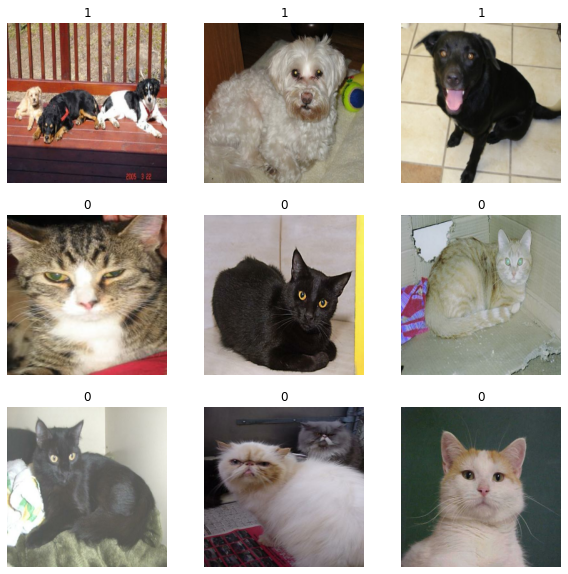

In [8]:
# Visualize the images:
plt.figure(figsize = (10,10))
for images, labels in training.take(1):
    for idx in range(9):
        ax = plt.subplot(3,3,idx + 1)
        ax.imshow(images[idx].numpy().astype("uint8"))
        ax.set_title(int(labels[idx]))
        ax.axis("off")
plt.show()

We can see clearly that our labels are as follow : 

*   Cat  =>  0
*   Dog  =>  1

They follow the same order as in the variable : **classes**



### Apply data augmentation

Since I am using CPU, I will apply data augmentation outside of the model.
This way it will happen asynchronously which means that it won't block the model during training.

In [9]:
# Apply realistic data augmentation
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.03)
    ]
)

augmented_training_ds = training.map(lambda x,y : (data_augmentation(x, training = True), y))

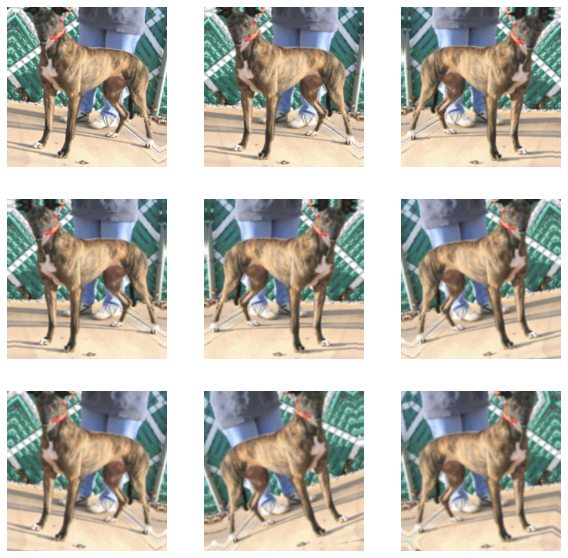

In [10]:
# Visualize the effect of the data augmentation
fig = plt.figure(figsize = (10,10))
for images, labels in training.take(1):
    for idx in range(9):
        images = data_augmentation(images)
        ax = plt.subplot(3,3,idx+1)
        ax.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
plt.show()

Lets use buffered prefetching to get data from disk without having I/O becoming blocking!

This is an interesting optimization.

In [11]:
augmented_training_ds = augmented_training_ds.prefetch(buffer_size=32)
validation = validation.prefetch(buffer_size=32)
test = test.prefetch(buffer_size=32)

# Create the model

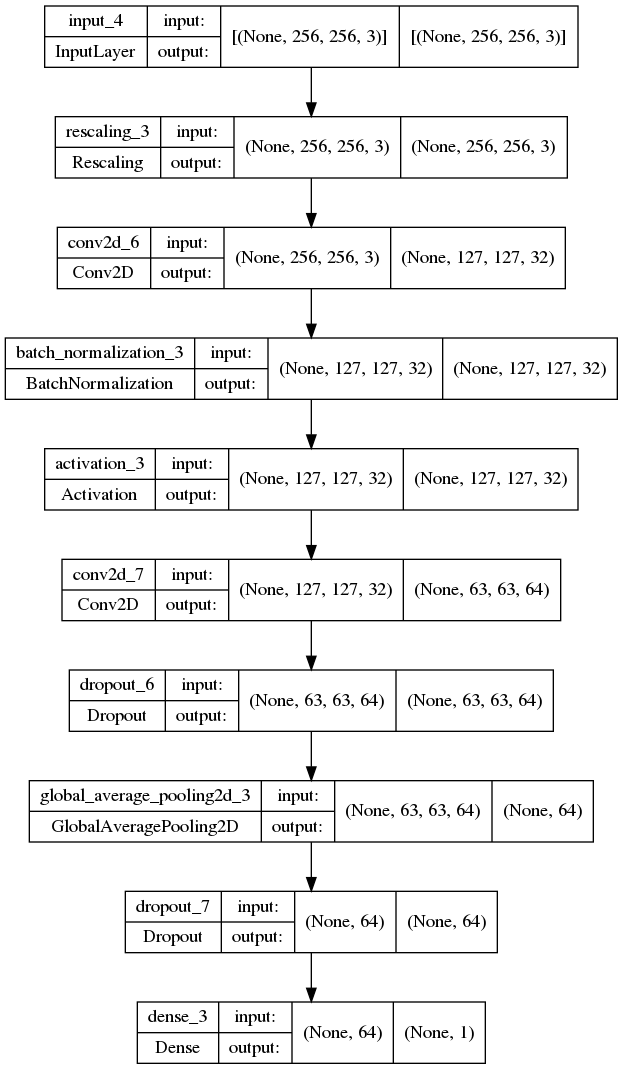

In [25]:
from tensorflow.keras import layers

def createModel(input_shape, num_classes = 2):
    input = layers.Input(shape=input_shape)
    x = layers.Rescaling(1.0 / 255)(input)
    x = layers.Conv2D(32, kernel_size = 3, strides = 2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(64, kernel_size = 3, strides = 2)(x)
    x = layers.Dropout(0.2)(x)
    #x = layers.Flatten()(x)
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    output = layers.Dense(units, activation = activation)(x)
    model = tf.keras.Model(input, output)
    return model

model = createModel(input_shape= image_size + (3,), num_classes= 2)
tf.keras.utils.plot_model(model, show_shapes= True)

# Compile and train the model

Compile the model.

* We will use the Adam optimizer (High efficiency).
* This is a classification problem so we must use the crossentropy loss function, and since we have two classes (Cats / Dogs) then **binray_crossentropy** is the best choice.

In [26]:
# Compile the model
model.compile(optimizer= tf.keras.optimizers.Adam(1e-3), loss = "binary_crossentropy", metrics=["accuracy"])

When training the model we will implement :
* Tensorboard : An awesome platforme to visualize the training and validation curves and debug training errors.

In [27]:
# Fit the model
nb_epochs ,logdir =  50, "logs"

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 10, min_delta= 0.01)
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint("best_model.h5",monitor= "val_accuracy", mode = "min",save_best_only=True)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir)

callbacks = [modelCheckpoint, tensorboard]
history = model.fit(augmented_training_ds, validation_data= validation, epochs=nb_epochs, callbacks=callbacks)

Epoch 1/50
45/63 [====================>.........] - ETA: 8s - loss: 0.7167 - accuracy: 0.5299

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 33s 506ms/step - loss: 0.7072 - accuracy: 0.5475 - val_loss: 0.6961 - val_accuracy: 0.5040
Epoch 2/50
44/63 [===================>..........] - ETA: 9s - loss: 0.7049 - accuracy: 0.5611

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 31s 487ms/step - loss: 0.7068 - accuracy: 0.5556 - val_loss: 0.6908 - val_accuracy: 0.5360
Epoch 3/50
43/63 [===================>..........] - ETA: 9s - loss: 0.6929 - accuracy: 0.5531

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 33s 510ms/step - loss: 0.6898 - accuracy: 0.5596 - val_loss: 0.6885 - val_accuracy: 0.5460
Epoch 4/50
39/63 [=================>............] - ETA: 14s - loss: 0.6882 - accuracy: 0.5577

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 38s 598ms/step - loss: 0.6826 - accuracy: 0.5691 - val_loss: 0.6811 - val_accuracy: 0.5360
Epoch 5/50
43/63 [===================>..........] - ETA: 10s - loss: 0.6811 - accuracy: 0.5596

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 36s 569ms/step - loss: 0.6784 - accuracy: 0.5696 - val_loss: 0.6768 - val_accuracy: 0.5720
Epoch 6/50
39/63 [=================>............] - ETA: 14s - loss: 0.6884 - accuracy: 0.5705

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 40s 625ms/step - loss: 0.6888 - accuracy: 0.5676 - val_loss: 0.6770 - val_accuracy: 0.5900
Epoch 7/50
42/63 [===================>..........] - ETA: 11s - loss: 0.6747 - accuracy: 0.5744

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 36s 562ms/step - loss: 0.6740 - accuracy: 0.5741 - val_loss: 0.6657 - val_accuracy: 0.5860
Epoch 8/50
44/63 [===================>..........] - ETA: 9s - loss: 0.6803 - accuracy: 0.5653

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 33s 520ms/step - loss: 0.6815 - accuracy: 0.5666 - val_loss: 0.6604 - val_accuracy: 0.5920
Epoch 9/50
44/63 [===================>..........] - ETA: 9s - loss: 0.6698 - accuracy: 0.5739 

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 35s 543ms/step - loss: 0.6700 - accuracy: 0.5751 - val_loss: 0.6668 - val_accuracy: 0.5740
Epoch 10/50
42/63 [===================>..........] - ETA: 10s - loss: 0.6679 - accuracy: 0.5685

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 33s 519ms/step - loss: 0.6719 - accuracy: 0.5711 - val_loss: 0.6851 - val_accuracy: 0.5620
Epoch 11/50
43/63 [===================>..........] - ETA: 9s - loss: 0.6708 - accuracy: 0.5799 

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 32s 498ms/step - loss: 0.6704 - accuracy: 0.5806 - val_loss: 0.6639 - val_accuracy: 0.5800
Epoch 12/50
41/63 [==================>...........] - ETA: 11s - loss: 0.6736 - accuracy: 0.5633

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 36s 565ms/step - loss: 0.6682 - accuracy: 0.5741 - val_loss: 0.7570 - val_accuracy: 0.5080
Epoch 13/50
43/63 [===================>..........] - ETA: 9s - loss: 0.6637 - accuracy: 0.5865 

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 33s 513ms/step - loss: 0.6633 - accuracy: 0.5931 - val_loss: 0.6666 - val_accuracy: 0.5780
Epoch 14/50
44/63 [===================>..........] - ETA: 9s - loss: 0.6685 - accuracy: 0.5859

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 32s 503ms/step - loss: 0.6719 - accuracy: 0.5836 - val_loss: 0.6640 - val_accuracy: 0.6000
Epoch 15/50
39/63 [=================>............] - ETA: 14s - loss: 0.6775 - accuracy: 0.5553

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 38s 592ms/step - loss: 0.6732 - accuracy: 0.5571 - val_loss: 0.6555 - val_accuracy: 0.6040
Epoch 16/50
41/63 [==================>...........] - ETA: 10s - loss: 0.6677 - accuracy: 0.5953

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 34s 532ms/step - loss: 0.6673 - accuracy: 0.5916 - val_loss: 0.9127 - val_accuracy: 0.4960
Epoch 17/50
44/63 [===================>..........] - ETA: 8s - loss: 0.6699 - accuracy: 0.5781

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 33s 519ms/step - loss: 0.6712 - accuracy: 0.5746 - val_loss: 0.6820 - val_accuracy: 0.5440
Epoch 18/50
42/63 [===================>..........] - ETA: 10s - loss: 0.6659 - accuracy: 0.5789

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 32s 506ms/step - loss: 0.6632 - accuracy: 0.5776 - val_loss: 0.6881 - val_accuracy: 0.5180
Epoch 19/50
47/63 [=====================>........] - ETA: 6s - loss: 0.6641 - accuracy: 0.5944

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 28s 437ms/step - loss: 0.6667 - accuracy: 0.5851 - val_loss: 1.0380 - val_accuracy: 0.5020
Epoch 20/50
47/63 [=====================>........] - ETA: 6s - loss: 0.6604 - accuracy: 0.5911

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 27s 423ms/step - loss: 0.6598 - accuracy: 0.5901 - val_loss: 0.6580 - val_accuracy: 0.5860
Epoch 21/50
43/63 [===================>..........] - ETA: 9s - loss: 0.6535 - accuracy: 0.6010

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 30s 465ms/step - loss: 0.6563 - accuracy: 0.5966 - val_loss: 0.6775 - val_accuracy: 0.5380
Epoch 22/50
43/63 [===================>..........] - ETA: 9s - loss: 0.6636 - accuracy: 0.5799 

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 34s 519ms/step - loss: 0.6579 - accuracy: 0.5921 - val_loss: 0.7411 - val_accuracy: 0.4980
Epoch 23/50
37/63 [================>.............] - ETA: 16s - loss: 0.6593 - accuracy: 0.5861

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 40s 629ms/step - loss: 0.6565 - accuracy: 0.5861 - val_loss: 0.7294 - val_accuracy: 0.5080
Epoch 24/50
38/63 [=================>............] - ETA: 15s - loss: 0.6547 - accuracy: 0.5938

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 38s 598ms/step - loss: 0.6582 - accuracy: 0.5976 - val_loss: 0.7245 - val_accuracy: 0.5080
Epoch 25/50
43/63 [===================>..........] - ETA: 9s - loss: 0.6548 - accuracy: 0.6039

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 29s 453ms/step - loss: 0.6569 - accuracy: 0.6046 - val_loss: 0.7127 - val_accuracy: 0.4980
Epoch 26/50
47/63 [=====================>........] - ETA: 6s - loss: 0.6558 - accuracy: 0.5938

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 26s 400ms/step - loss: 0.6615 - accuracy: 0.5836 - val_loss: 0.7258 - val_accuracy: 0.4980
Epoch 27/50
47/63 [=====================>........] - ETA: 6s - loss: 0.6569 - accuracy: 0.5944

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 27s 431ms/step - loss: 0.6585 - accuracy: 0.5921 - val_loss: 0.6776 - val_accuracy: 0.5420
Epoch 28/50
43/63 [===================>..........] - ETA: 8s - loss: 0.6560 - accuracy: 0.6032

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 29s 443ms/step - loss: 0.6591 - accuracy: 0.5971 - val_loss: 0.7036 - val_accuracy: 0.5160
Epoch 29/50
44/63 [===================>..........] - ETA: 8s - loss: 0.6501 - accuracy: 0.6016

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 29s 458ms/step - loss: 0.6526 - accuracy: 0.5961 - val_loss: 0.7951 - val_accuracy: 0.5060
Epoch 30/50
47/63 [=====================>........] - ETA: 6s - loss: 0.6531 - accuracy: 0.5911

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 28s 439ms/step - loss: 0.6598 - accuracy: 0.5826 - val_loss: 0.7010 - val_accuracy: 0.5100
Epoch 31/50
47/63 [=====================>........] - ETA: 6s - loss: 0.6543 - accuracy: 0.5904

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 25s 399ms/step - loss: 0.6564 - accuracy: 0.5836 - val_loss: 0.6603 - val_accuracy: 0.5680
Epoch 32/50
47/63 [=====================>........] - ETA: 6s - loss: 0.6540 - accuracy: 0.5911

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 27s 419ms/step - loss: 0.6550 - accuracy: 0.5876 - val_loss: 0.6357 - val_accuracy: 0.6340
Epoch 33/50
45/63 [====================>.........] - ETA: 7s - loss: 0.6503 - accuracy: 0.5972

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 28s 433ms/step - loss: 0.6517 - accuracy: 0.6056 - val_loss: 0.7555 - val_accuracy: 0.5100
Epoch 34/50
47/63 [=====================>........] - ETA: 6s - loss: 0.6549 - accuracy: 0.5911

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 27s 416ms/step - loss: 0.6587 - accuracy: 0.5841 - val_loss: 0.9700 - val_accuracy: 0.5020
Epoch 35/50
42/63 [===================>..........] - ETA: 9s - loss: 0.6565 - accuracy: 0.5982 

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 30s 477ms/step - loss: 0.6535 - accuracy: 0.5961 - val_loss: 0.7258 - val_accuracy: 0.4980
Epoch 36/50
45/63 [====================>.........] - ETA: 7s - loss: 0.6501 - accuracy: 0.5958

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 29s 456ms/step - loss: 0.6520 - accuracy: 0.5961 - val_loss: 0.6371 - val_accuracy: 0.6440
Epoch 37/50
46/63 [====================>.........] - ETA: 7s - loss: 0.6493 - accuracy: 0.5992

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 28s 436ms/step - loss: 0.6549 - accuracy: 0.5951 - val_loss: 0.7147 - val_accuracy: 0.5220
Epoch 38/50
47/63 [=====================>........] - ETA: 6s - loss: 0.6506 - accuracy: 0.6037

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 27s 416ms/step - loss: 0.6531 - accuracy: 0.6021 - val_loss: 0.7073 - val_accuracy: 0.5260
Epoch 39/50
47/63 [=====================>........] - ETA: 6s - loss: 0.6492 - accuracy: 0.6031

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 25s 397ms/step - loss: 0.6548 - accuracy: 0.5966 - val_loss: 0.6480 - val_accuracy: 0.5920
Epoch 40/50
47/63 [=====================>........] - ETA: 6s - loss: 0.6580 - accuracy: 0.5904

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 25s 396ms/step - loss: 0.6551 - accuracy: 0.5951 - val_loss: 0.6339 - val_accuracy: 0.6380
Epoch 41/50
47/63 [=====================>........] - ETA: 5s - loss: 0.6487 - accuracy: 0.6024

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 25s 393ms/step - loss: 0.6506 - accuracy: 0.6001 - val_loss: 0.6663 - val_accuracy: 0.5520
Epoch 42/50
47/63 [=====================>........] - ETA: 6s - loss: 0.6510 - accuracy: 0.6031

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 27s 422ms/step - loss: 0.6506 - accuracy: 0.6031 - val_loss: 0.8524 - val_accuracy: 0.5020
Epoch 43/50
46/63 [====================>.........] - ETA: 7s - loss: 0.6574 - accuracy: 0.6060

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 28s 434ms/step - loss: 0.6544 - accuracy: 0.6086 - val_loss: 0.6443 - val_accuracy: 0.5960
Epoch 44/50
47/63 [=====================>........] - ETA: 6s - loss: 0.6484 - accuracy: 0.6064

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 27s 420ms/step - loss: 0.6527 - accuracy: 0.6011 - val_loss: 0.7945 - val_accuracy: 0.5000
Epoch 45/50
47/63 [=====================>........] - ETA: 6s - loss: 0.6542 - accuracy: 0.5891

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 26s 405ms/step - loss: 0.6546 - accuracy: 0.5931 - val_loss: 0.6674 - val_accuracy: 0.5560
Epoch 46/50
45/63 [====================>.........] - ETA: 7s - loss: 0.6479 - accuracy: 0.6014

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 28s 436ms/step - loss: 0.6513 - accuracy: 0.6031 - val_loss: 0.7032 - val_accuracy: 0.5120
Epoch 47/50
47/63 [=====================>........] - ETA: 6s - loss: 0.6534 - accuracy: 0.6084

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 26s 400ms/step - loss: 0.6516 - accuracy: 0.6071 - val_loss: 0.6589 - val_accuracy: 0.5640
Epoch 48/50
47/63 [=====================>........] - ETA: 6s - loss: 0.6495 - accuracy: 0.5991

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 25s 400ms/step - loss: 0.6565 - accuracy: 0.5946 - val_loss: 0.6439 - val_accuracy: 0.5960
Epoch 49/50
46/63 [====================>.........] - ETA: 6s - loss: 0.6522 - accuracy: 0.6026

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 27s 418ms/step - loss: 0.6526 - accuracy: 0.6011 - val_loss: 0.6466 - val_accuracy: 0.5920
Epoch 50/50
47/63 [=====================>........] - ETA: 6s - loss: 0.6492 - accuracy: 0.5991

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


63/63 [==============================] - 25s 398ms/step - loss: 0.6496 - accuracy: 0.6021 - val_loss: 0.7229 - val_accuracy: 0.5160


# Evaluate the model's performance

In [28]:
model = tf.keras.models.load_model("./best_model.h5")
loss, accuracy = tuple(model.evaluate(validation))

16/16 [==============================] - 1s 67ms/step - loss: 0.9127 - accuracy: 0.4960


In [29]:
print(f"Loss = {loss} and accuracy = {accuracy}")

Loss = 0.9126875400543213 and accuracy = 0.4959999918937683


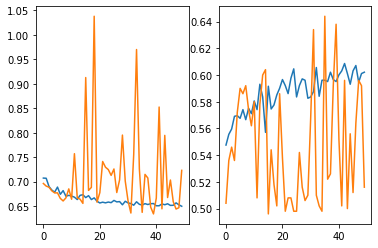

In [43]:
#%load_ext tensorboard
#%tensorboard --logdir=logdir
fig = plt.figure()
ax_loss = plt.subplot(1,2,1)
ax_loss.plot(history.history["loss"])
ax_loss.plot(history.history["val_loss"])
ax_accuracy = plt.subplot(1,2,2)
ax_accuracy.plot(history.history["accuracy"])
ax_accuracy.plot(history.history["val_accuracy"])
plt.show()